# Trabalho da disciplina Projeto/MVP em Ciência de Dados

## Aluno: Luis Eduardo Ribeiro Veiga - RA: 40520223000855

## Notebook modelo Clássico

In [35]:
#-----

## Notebook modelo Deep Learning - Classificador de imagens do dataset CIFAR10

**Descrição do Problema** - Criar um modelo de visão computacional para classificar uma imagem em alguma das categorias presentes no dataset CIPHAR10.

**Dataset** - O dataset CIFAR-10 é composto por 60000 imagens a cores 32x32 em 10 classes, com 6000 imagens por classe. Existem 50000 imagens de treino e 10000 imagens de teste. 

As classes presentes no dataset são: airplane, automobile, bird, cat, deer, dog, frog, horse, ship e truck.

### Importação de bibliotecas

In [36]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
import os
#from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from tensorflow import keras
from sklearn.metrics import confusion_matrix #, classification_report
import sklearn.metrics as skm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [37]:
gpu_dev_name = tf.test.gpu_device_name()
if gpu_dev_name != '/device:GPU:0':
  print('GPU não encontrada')
else:
    print('GPU encontrada em: {}'.format(gpu_dev_name))

GPU não encontrada


### Funções utilitárias

In [38]:
# Prepara dataframe com os dados lidos a partir do dataset CIFAR10 
def prepare_dataset(X_dataset, y_dataset, classes, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    df_aux = pd.DataFrame(columns=['id', 'label'])

    list_aux = []

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        sample = {'id':nm_file, 'label':str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')}
        list_aux.append(sample)

    return pd.concat([df_aux, pd.DataFrame(list_aux)], ignore_index=True)

# Cria arquivos nos diretórios de trabalho com as imagens contidas no dataset CIFAR10
def create_files(X_dataset, y_dataset, classes, dir, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        img = X_dataset[i]
        plt.imsave(dir + nm_file, img)

# Cria os diretórios de trabalho usados no processamento do código no notebook
def create_directory(dir):
    if os.path.exists(dir):
        for file in os.listdir(dir):
            os.remove(dir+file)
    else:
        os.makedirs(dir)

# Plota gráfico com a evolução do valor loss em função da época
def plot_loss(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss X epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Plota gráfico com a evolução do valor accuracy em função da época
def plot_accuracy(history):  
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy X epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Plota matriz de confusão
def plot_confusion_matrix(actual, predicted, class_names):
    cnf_matrix = confusion_matrix(actual, predicted, labels=class_names)
    np.set_printoptions(precision=2)

    fig, ax = plt.subplots(figsize=(5, 5))
    cax = ax.matshow(cnf_matrix, cmap=plt.cm.Blues, alpha=0.3, interpolation = 'nearest')
    plt.gca().xaxis.tick_bottom()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            ax.text(x=j, y=i,s=cnf_matrix[i, j], va='center', ha='center')

    fig.colorbar(cax)

    plt.xlabel('Predição', fontsize=13)
    plt.ylabel('Real', fontsize=13)
    plt.title('Matriz de Confusão', fontsize=18)
    plt.show()

# Define configuração do modelo 1
def model1(p_train_generator, p_test_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs):
    model1 = models.Sequential()

    model1.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

    model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model1.add(layers.Flatten())
    model1.add(layers.Dense(512, activation='relu'))
    model1.add(layers.Dense(10, activation='softmax'))
    
    model1.summary()

    history = compile_fit_model(model1, p_train_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs)

    loss, accuracy = display_result_model (model1, p_test_generator, history)

    return model1, loss, accuracy

# Define configuração do modelo 2
def model2(p_train_generator, p_test_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs):
    model2 = models.Sequential()

    model2.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

    model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model2.add(layers.Dropout(0.25))

    model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model2.add(layers.Dropout(0.25))

    model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model2.add(layers.Dropout(0.25))

    model2.add(layers.Flatten())
    model2.add(layers.Dense(512, activation='relu'))
    model2.add(layers.Dropout(0.25))
    model2.add(layers.Dense(10, activation='softmax'))
    
    model2.summary()
    
    history = compile_fit_model(model2, p_train_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs)

    loss, accuracy = display_result_model (model2, p_test_generator, history)

    return model2, loss, accuracy

# Define configuração do modelo 3
def model3(p_train_generator, p_test_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs):
    model3 = models.Sequential()

    model3.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

    model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model3.add(layers.Dropout(0.25))

    model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model3.add(layers.Dropout(0.25))

    model3.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model3.add(layers.Dropout(0.25))

    model3.add(layers.Flatten())
    model3.add(layers.Dense(512, activation='relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.Dropout(0.25))
    model3.add(layers.Dense(10, activation='softmax'))
    
    model3.summary()
    
    history = compile_fit_model(model3, p_train_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs)

    loss, accuracy = display_result_model (model3, p_test_generator, history)

    return model3, loss, accuracy

# Define configuração do modelo 4
def model4(p_train_generator, p_test_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs):
    model4 = models.Sequential()

    model4.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

    model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model4.add(layers.BatchNormalization())
    model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model4.add(layers.BatchNormalization())
    model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model4.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model4.add(layers.BatchNormalization())
    model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model4.add(layers.Flatten())
    model4.add(layers.Dense(512, activation='relu'))
    model4.add(layers.BatchNormalization())
    model4.add(layers.Dense(10, activation='softmax'))
    
    model4.summary()
    
    history = compile_fit_model(model4, p_train_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs)

    loss, accuracy = display_result_model (model4, p_test_generator, history)

    return model4, loss, accuracy

# Processa a compilação e a função fit em um modelo
def compile_fit_model(p_model, p_train_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs):
    p_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = p_model.fit_generator(generator=p_train_generator,
          validation_data=p_valid_generator,
          steps_per_epoch=p_train_step_size,
          validation_steps=p_validation_step_size,
          epochs=p_epochs)
    
    return history

# Apresenta resultados do processamento de determinada operação no modelo
def display_result_model (p_model, p_test_generator, p_history):
    plot_loss(p_history)
    plot_accuracy(p_history)

    loss, accuracy = p_model.evaluate_generator(p_test_generator)
    print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

    return loss, accuracy

# Plota informações sobre um dataset
def plot_dataset_class(p_dataset, p_title):
    print((p_dataset['label']).value_counts())
    p_dataset['label'].value_counts().plot.bar(title=p_title)


### Carga e preparação dos dados

Carrega o dataset, separa entre treino e teste e monta a lista de classes das imagens.

In [39]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Cria os diretórios de trabalho.

In [40]:
train_dir = "./train/"
test_dir = "./test/" 

create_directory(train_dir)
create_directory(test_dir)

Define o tamanho das amostras de treino e teste usadas no processamento do notebook.

In [41]:
v_train_samples = 1000 
v_test_samples = 200 
# v_train_samples = X_train.shape[0]
# v_test_samples = X_test.shape[0]

Cria os arquivos de imagens de treinamento nos diretórios de trabalho e prepara o dataframe de treinamento usado no processamento do notebook.

In [42]:
train_samples = v_train_samples

create_files(X_train, y_train, cifar10_classes, train_dir, train_samples)

train_df = prepare_dataset(X_train, y_train, cifar10_classes, train_samples)

train_df.head()

,id,label
0,0-frog.png,frog
1,1-truck.png,truck
2,2-truck.png,truck
3,3-deer.png,deer
4,4-automobile.png,automobile


Cria os arquivos de imagens de teste nos diretórios de trabalho e prepara o dataframe de teste usado no processamento do notebook.

In [43]:
test_samples = v_test_samples

create_files(X_test, y_test, cifar10_classes, test_dir, test_samples)

test_df = prepare_dataset(X_test, y_test, cifar10_classes, test_samples)

test_df.head()

,id,label
0,0-cat.png,cat
1,1-ship.png,ship
2,2-ship.png,ship
3,3-airplane.png,airplane
4,4-frog.png,frog


Apresenta informações sobre os dados de treinamento.

label
automobile    112
frog          107
truck         103
horse         102
airplane      102
deer           99
bird           99
ship           99
cat            92
dog            85
Name: count, dtype: int64


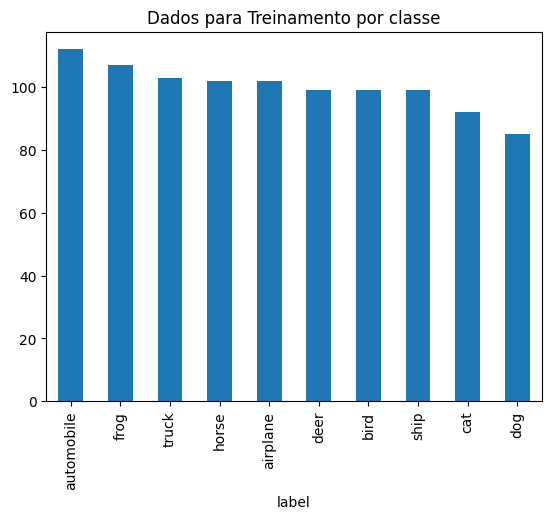

In [44]:
plot_dataset_class(train_df, 'Dados para Treinamento por classe')

Apresenta informações sobre os dados de teste.

label
ship          28
frog          26
truck         21
bird          21
airplane      20
cat           19
dog           18
horse         18
deer          15
automobile    14
Name: count, dtype: int64


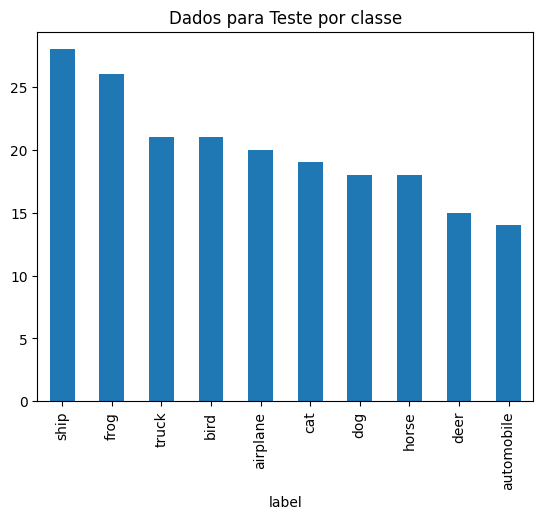

In [45]:
plot_dataset_class(test_df, 'Dados para Teste por classe')

In [46]:
print('Total de imagens para treinamento: %s' % len(os.listdir(train_dir)))
print('Total de imagens para teste      : %s' % len(os.listdir(test_dir)))

Total de imagens para treinamento: 1000
Total de imagens para teste      : 200


Classes: ['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship', 'cat']


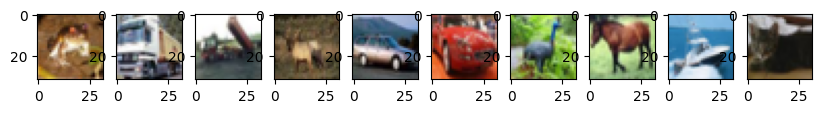

In [47]:
fig, x = plt.subplots(1, 10)
fig.set_size_inches(10, 10)

print('Classes: ' + str([cifar10_classes[x[0]] for x in y_train[0:10]]))

for i in range(10):
    image = X_train[i]
    x[i].imshow(image)

plt.show()

In [48]:
train_datagen=ImageDataGenerator(rescale=1.0/255.0,
                                validation_split=0.25,
                                rotation_range=30,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True                                
                                )

train_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

Found 750 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.


In [49]:
test_datagen=ImageDataGenerator(rescale=1.0/255.0)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory=test_dir,
x_col="id",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(32,32))

Found 200 validated image filenames belonging to 10 classes.


### Modelagem e treinamento

In [50]:
train_step_size = train_generator.n//train_generator.batch_size
validation_step_size = valid_generator.n//valid_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size

v_epochs = 30

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 4, 4, 128)        

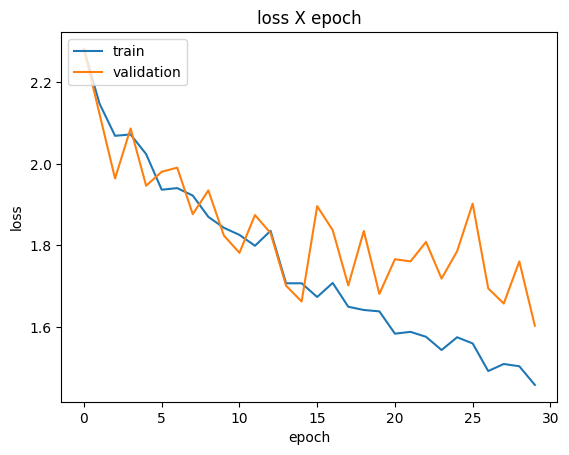

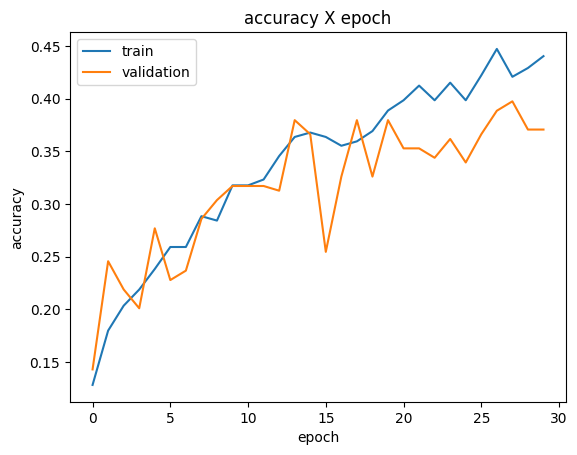

Test: accuracy = 0.385000  ;  loss = 1.704917 


In [51]:
model1, loss1, accuracy1 = model1(train_generator, test_generator, valid_generator, train_step_size, validation_step_size, v_epochs)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                 

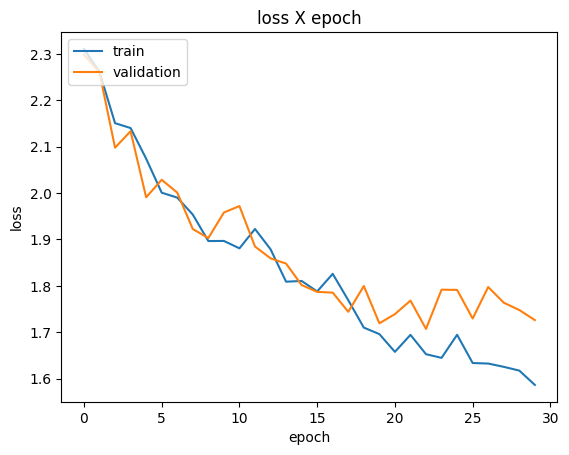

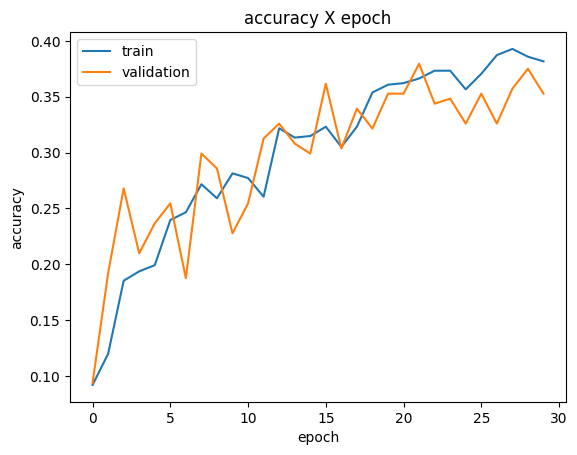

Test: accuracy = 0.440000  ;  loss = 1.647891 


In [52]:
model2, loss2, accuracy2 = model2(train_generator, test_generator, valid_generator, train_step_size, validation_step_size, v_epochs)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_8 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 12, 12, 128)      

 batch_normalization_10 (Bat  (None, 4, 4, 256)        1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 2, 2, 256)        0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 2, 2, 256)         0         
                                                                 
 flatten_6 (Flatten)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_11 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_1

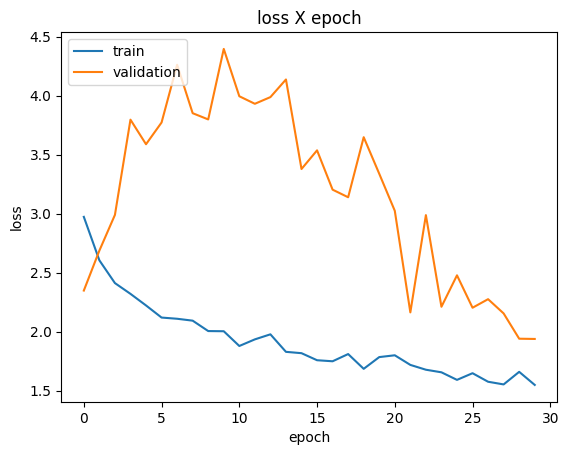

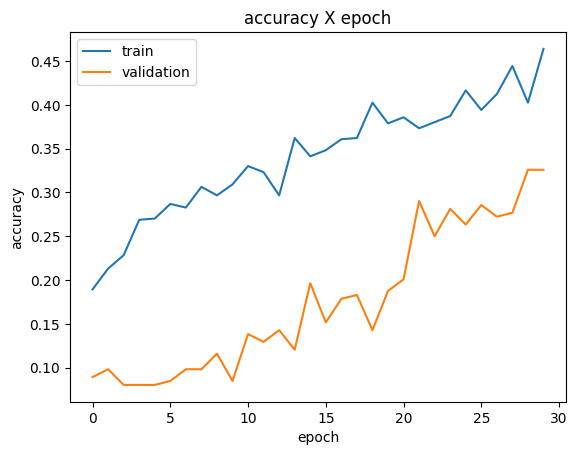

Test: accuracy = 0.420000  ;  loss = 1.810146 


In [53]:
model3, loss3, accuracy3 = model3(train_generator, test_generator, valid_generator, train_step_size, validation_step_size, v_epochs)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 batch_normalization_13 (Bat  (None, 12, 12, 128)     

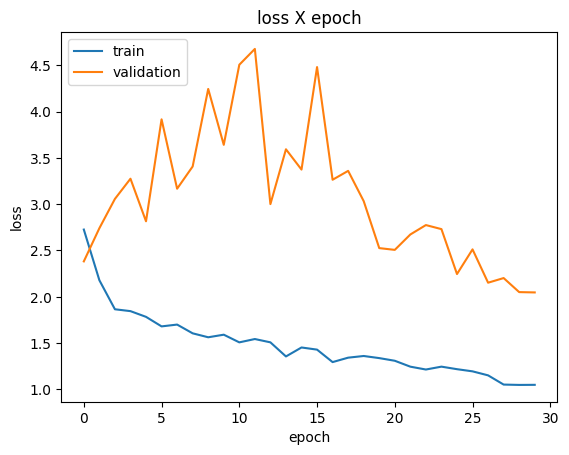

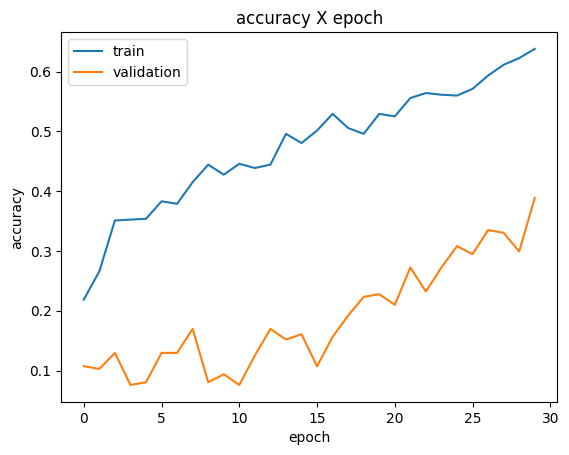

Test: accuracy = 0.400000  ;  loss = 1.952015 


In [54]:
model4, loss4, accuracy4 = model4(train_generator, test_generator, valid_generator, train_step_size, validation_step_size, v_epochs)

In [55]:
print('Resultado dos Modelos')
print('---------------------------')
table_result_model = [[accuracy1, loss1], [accuracy2, loss2], [accuracy3, loss3], [accuracy4, loss4]]
df_result_model = pd.DataFrame(table_result_model, columns = ['accuracy', 'loss'], index=['Model 1', 'Model 2', 'Model 3', 'Model 4'])
print(df_result_model)

Resultado dos Modelos
---------------------------
         accuracy      loss
Model 1     0.385  1.704917
Model 2     0.440  1.647891
Model 3     0.420  1.810146
Model 4     0.400  1.952015


In [56]:
model_accuracy = {
    'model1': accuracy1,
    'model2': accuracy2,
    'model3': accuracy3,
    'model4': accuracy4
}

model_selec = max(model_accuracy, key=model_accuracy.get)

print('Modelo escolhido: ' + model_selec)

if model_selec == 'model1':
    model = model1
elif model_selec == 'model2':
    model = model2
elif model_selec == 'model3':
    model = model3
else:
    model = model4

Modelo escolhido: model2


In [57]:
test_generator.reset()
pred=model.predict_generator(test_generator)

In [58]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.440000  ;  loss = 1.647891 


In [59]:
predicted_class_indices=np.argmax(pred,axis=1)

In [60]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [61]:
test_generator.reset()

count = 0
actuals = list()

for batch in test_generator:
    count+=1
    if count == len(test_generator)+1:
        break
    else:
        images = batch[0]
        labels = batch[1]
        for i in range(len(images)):
            label = labels[i]
            labeled_class = np.argmax(label)
            label = cifar10_classes[int(labeled_class)]
            actuals.append(label)

accuracy = skm.accuracy_score(actuals, predictions)
precision = skm.precision_score(actuals, predictions, average='weighted')
recall = skm.recall_score(actuals, predictions, average='weighted')
f1score = skm.f1_score(actuals, predictions, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

Accuracy:  0.44
Precision:  0.4871996927803379
Recall:  0.44
F1 Score:  0.43346745802363273


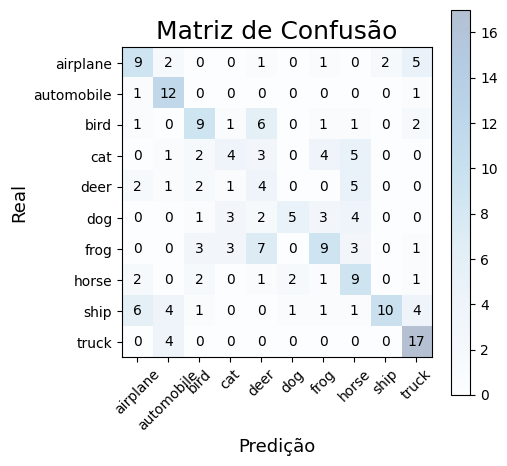

In [62]:
plot_confusion_matrix(actuals, predictions, cifar10_classes)

In [63]:
model_dir = "./trained_models/"
create_directory(model_dir)

model_name = 'trained_model_deep_learning.h5'

model.save("%s/%s" % (model_dir, model_name))
print("Modelo salvo com o nome: ", model_name)

Modelo salvo com o nome:  trained_model_deep_learning.h5


In [64]:
model_loaded = keras.models.load_model("%s/%s" % (model_dir, model_name))
print("Modelo %s carregado com sucesso" % (model_name))

Modelo trained_model_deep_learning.h5 carregado com sucesso


1/1 [==============================] - 0s 58ms/step


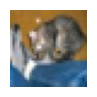

Label:  cat
Previsão:  frog
Probabilidade:  0.3818113


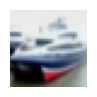

Label:  ship
Previsão:  automobile
Probabilidade:  0.8056509


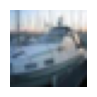

Label:  ship
Previsão:  airplane
Probabilidade:  0.2870109


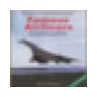

Label:  airplane
Previsão:  airplane
Probabilidade:  0.4010281


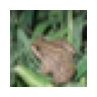

Label:  frog
Previsão:  deer
Probabilidade:  0.38187376


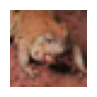

Label:  frog
Previsão:  frog
Probabilidade:  0.30755004


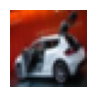

Label:  automobile
Previsão:  automobile
Probabilidade:  0.54760045


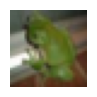

Label:  frog
Previsão:  bird
Probabilidade:  0.37510616


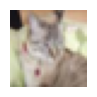

Label:  cat
Previsão:  bird
Probabilidade:  0.3031614


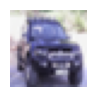

Label:  automobile
Previsão:  automobile
Probabilidade:  0.6499914


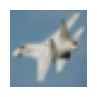

Label:  airplane
Previsão:  airplane
Probabilidade:  0.3795001


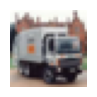

Label:  truck
Previsão:  truck
Probabilidade:  0.6367271


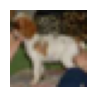

Label:  dog
Previsão:  frog
Probabilidade:  0.3903756


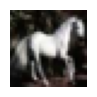

Label:  horse
Previsão:  horse
Probabilidade:  0.4030878


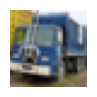

Label:  truck
Previsão:  truck
Probabilidade:  0.48685777


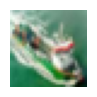

Label:  ship
Previsão:  frog
Probabilidade:  0.42869693


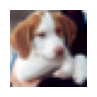

Label:  dog
Previsão:  cat
Probabilidade:  0.39763448


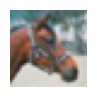

Label:  horse
Previsão:  horse
Probabilidade:  0.26645896


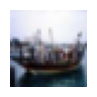

Label:  ship
Previsão:  truck
Probabilidade:  0.4758792


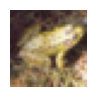

Label:  frog
Previsão:  deer
Probabilidade:  0.3326841


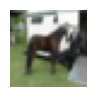

Label:  horse
Previsão:  truck
Probabilidade:  0.44979864


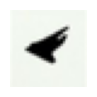

Label:  airplane
Previsão:  airplane
Probabilidade:  0.56893605


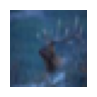

Label:  deer
Previsão:  airplane
Probabilidade:  0.24525581


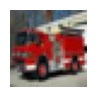

Label:  truck
Previsão:  truck
Probabilidade:  0.561104


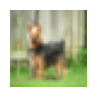

Label:  dog
Previsão:  deer
Probabilidade:  0.34080586


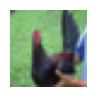

Label:  bird
Previsão:  bird
Probabilidade:  0.29033405


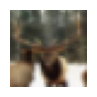

Label:  deer
Previsão:  cat
Probabilidade:  0.22050905


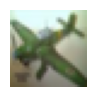

Label:  airplane
Previsão:  deer
Probabilidade:  0.2525369


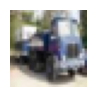

Label:  truck
Previsão:  truck
Probabilidade:  0.3877444


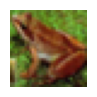

Label:  frog
Previsão:  cat
Probabilidade:  0.28431556


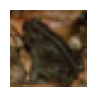

Label:  frog
Previsão:  deer
Probabilidade:  0.1967889


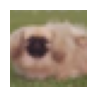

Label:  dog
Previsão:  deer
Probabilidade:  0.33434254
1/1 [==============================] - 0s 22ms/step


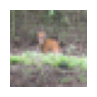

Label:  deer
Previsão:  deer
Probabilidade:  0.30872452


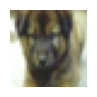

Label:  dog
Previsão:  frog
Probabilidade:  0.20981881


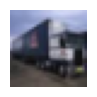

Label:  truck
Previsão:  truck
Probabilidade:  0.6676941


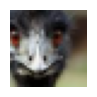

Label:  bird
Previsão:  truck
Probabilidade:  0.3280201


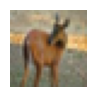

Label:  deer
Previsão:  horse
Probabilidade:  0.3441519


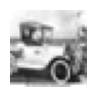

Label:  automobile
Previsão:  automobile
Probabilidade:  0.42405695


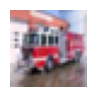

Label:  truck
Previsão:  automobile
Probabilidade:  0.5988383


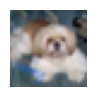

Label:  dog
Previsão:  cat
Probabilidade:  0.25397673


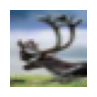

Label:  deer
Previsão:  automobile
Probabilidade:  0.4130157


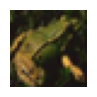

Label:  frog
Previsão:  frog
Probabilidade:  0.28537393


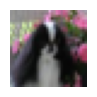

Label:  dog
Previsão:  dog
Probabilidade:  0.4856873


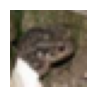

Label:  frog
Previsão:  frog
Probabilidade:  0.47603944


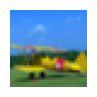

Label:  airplane
Previsão:  airplane
Probabilidade:  0.4464714


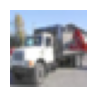

Label:  truck
Previsão:  truck
Probabilidade:  0.36538586


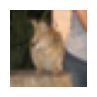

Label:  cat
Previsão:  deer
Probabilidade:  0.2860627


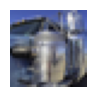

Label:  truck
Previsão:  truck
Probabilidade:  0.21634454


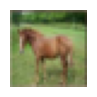

Label:  horse
Previsão:  deer
Probabilidade:  0.44691938


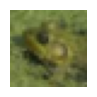

Label:  frog
Previsão:  deer
Probabilidade:  0.3659267


In [65]:
test_generator.reset()

count = 0
y_pred = list()
y_true = list()

img_count = 0
max_img = 50

# Loop do data generator de teste que contem as imagens
for batch in test_generator:
    count+=1

    # Condição de saída do loop. Só executaremos o modelo em algumas imagens
    if count == len(test_generator)+1 or img_count > max_img:
        break

    else:
        # Pegando a imagem e o label
        images = batch[0]
        labels = batch[1]

        # Previsão
        predictions = model_loaded.predict(images)

        # Visualização da imagem
        for i in range(len(images)):
            img_count+=1

            if img_count > max_img:
                break
            else:

                image = images[i]
                label = labels[i]

                prediction = predictions[i]

                # Converte o array de previsão para visualizar a classe e a probabilidade
                predicted_class = np.argmax(prediction)
                probability = prediction[predicted_class]

                labeled_class = np.argmax(label)
                label = cifar10_classes[int(labeled_class)]

                y_true.append(label)

                # Faz o DE-PARA da probabilidade com o tipo de classe da previsão
                # class_name = 'dog' if prediction >= 0.5 else 'cat'

                class_name = cifar10_classes[int(predicted_class)]

                y_pred.append(class_name)

                # Configura a saída das imagens que serão visualizadas
                
                fig, x = plt.subplots(1, 1)
                fig.set_size_inches(1, 1)

                plt.imshow(images[i])
                plt.axis('Off')
                plt.show()
                
                # Imprime os resultados da classificação das images
                print("Label: ", label)
                print("Previsão: ", class_name) 
                print("Probabilidade: ", probability) 